![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings_JSL/Finance/10.1.Image_Classification_with_Transformers.ipynb)

# Image Classification with Transformers

## Colab Setup

In [ ]:
# Install the johnsnowlabs library to access Spark-OCR and Spark-NLP for Healthcare, Finance, and Legal.
! pip install johnsnowlabs 

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

In [ ]:
from johnsnowlabs import nlp, finance, visual
# After uploading your license run this to install all licensed Python Wheels and pre-download Jars the Spark Session JVM
# Make sure to restart your notebook afterwards for changes to take effect
nlp.install()

# Start Spark Session

In [ ]:
from johnsnowlabs import nlp, finance, visual
# Automatically load license data and start a session with all jars user has access to
spark = nlp.start()

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
# if you want to start the session with custom params as in start function above
def start(SECRET):
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "16G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2000M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:"+PUBLIC_VERSION) \
        .config("spark.jars", "https://pypi.johnsnowlabs.com/"+SECRET+"/spark-nlp-jsl-"+JSL_VERSION+".jar")
      
    return builder.getOrCreate()

#spark = start(SECRET)

# **Identify Receipts in Pictures**

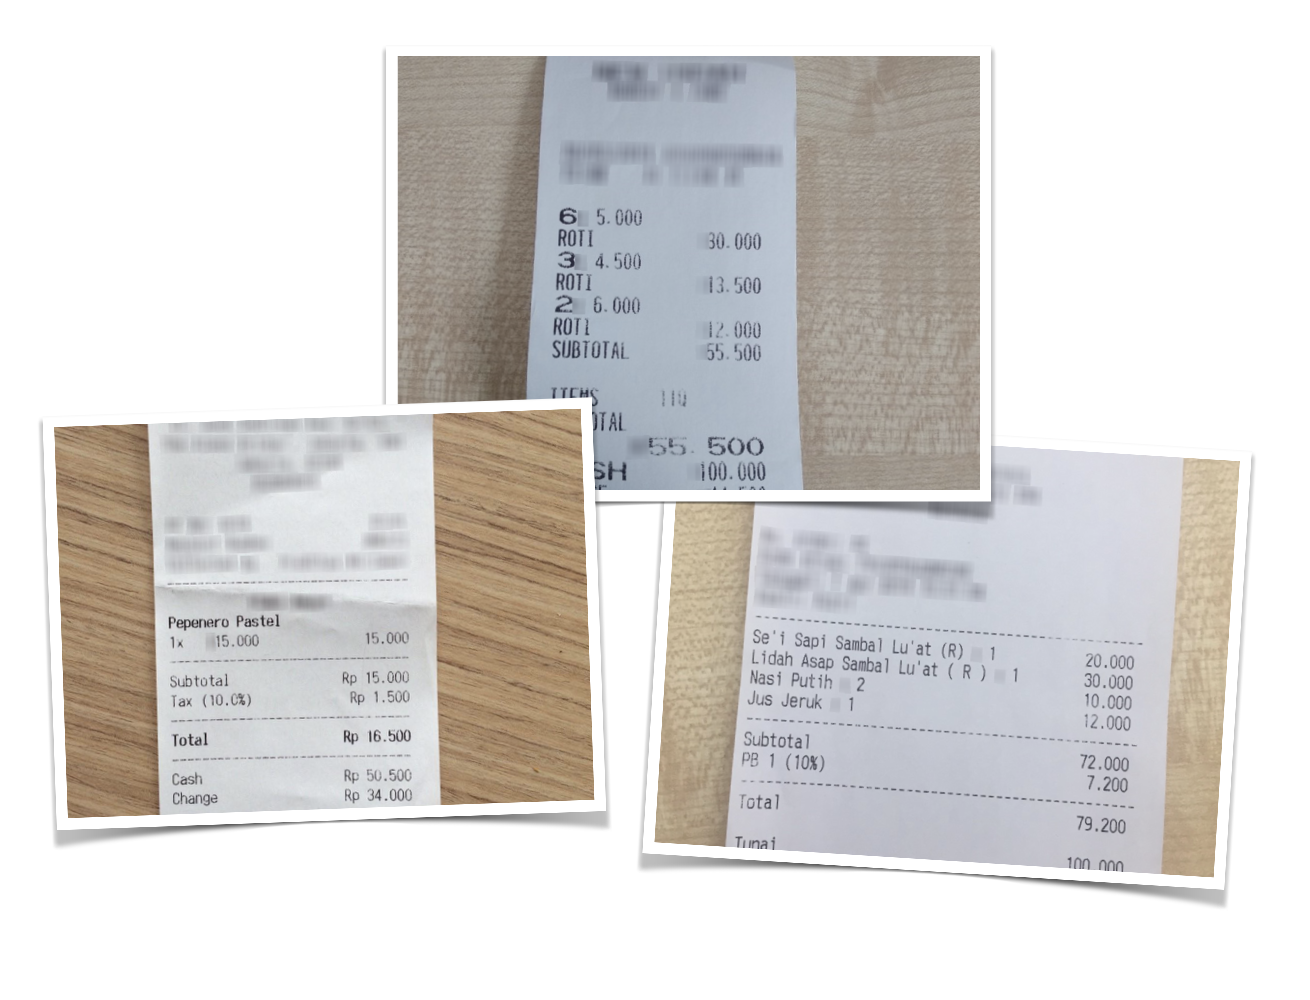

🔎 With this model, you can detect Receipts on both scanned and mobile images using Financial Image Transformers (ViT) in Spark NLP. You can use this model to retrieve all the images which are tickets and then process then using VisualNER, OCR, etc.

🔎 **`finvisualclf_tickets`** is a ViT (Visual Transformer) model, which can be used to carry out Binary Classification (true or false) on pictures / photos / images. This model has been trained in-house with different corpora, including:

* CORD
* COCO
* In-house annotated tickets

🔎 Classes detected by the model:

* **ticket**
* **no_ticket** 

## Load test images

In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings_JSL/Finance/data/receipt_sample_images/image01.png
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings_JSL/Finance/data/receipt_sample_images/image02.png
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings_JSL/Finance/data/receipt_sample_images/image03.png
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings_JSL/Finance/data/receipt_sample_images/image04.png
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings_JSL/Finance/data/receipt_sample_images/image05.png
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings_JSL/Finance/data/receipt_sample_images/image06.png

In [ ]:
test_image = spark.read\
    .format("image")\
    .option("dropInvalid", value = True)\
    .load("*.png").toDF("image")


In [ ]:
test_image.select("image.origin", "image.width", "image.height").show(truncate=False)

+---------------------------+-----+------+
|origin                     |width|height|
+---------------------------+-----+------+
|file:///content/image05.png|960  |1280  |
|file:///content/image01.png|1108 |1478  |
|file:///content/image02.png|1920 |2889  |
|file:///content/image06.png|1556 |1760  |
|file:///content/image04.png|1275 |1650  |
|file:///content/image03.png|1108 |1478  |
+---------------------------+-----+------+



# Prediction Pipeline

In [ ]:
document_assembler = nlp.ImageAssembler() \
    .setInputCol("image") \
    .setOutputCol("image_assembler")

imageClassifier_loaded = nlp.ViTForImageClassification.pretrained("finvisualclf_vit_tickets", "en", "finance/models")\
  .setInputCols(["image_assembler"])\
  .setOutputCol("class")

pipeline = nlp.Pipeline().setStages([
                            document_assembler,
                            imageClassifier_loaded])

finvisualclf_vit_tickets download started this may take some time.
Approximate size to download 306.9 MB
[OK!]


# Call pipeline

In [ ]:
result = pipeline.fit(test_image).transform(test_image).cache()

# Show results

In [ ]:
result.show()

+--------------------+--------------------+--------------------+
|               image|     image_assembler|               class|
+--------------------+--------------------+--------------------+
|{file:///content/...|[{image, file:///...|[{category, 0, 5,...|
|{file:///content/...|[{image, file:///...|[{category, 0, 5,...|
|{file:///content/...|[{image, file:///...|[{category, 0, 8,...|
|{file:///content/...|[{image, file:///...|[{category, 0, 8,...|
|{file:///content/...|[{image, file:///...|[{category, 0, 8,...|
|{file:///content/...|[{image, file:///...|[{category, 0, 5,...|
+--------------------+--------------------+--------------------+



In [ ]:
result_df = result.select(F.explode(F.arrays_zip("class.result","class.metadata")).alias("cols"))\
                  .select(F.expr("cols['1']['origin']").alias("images"),
                          F.expr("cols['0']").alias("class"),
                          F.expr("cols['1']['Some(ticket)']").alias("ticket_confidence"),
                          F.expr("cols['1']['Some(no_ticket)']").alias("no_ticket_confidence"))
                          

result_df.show(truncate=False)

+---------------------------+---------+-----------------+--------------------+
|images                     |class    |ticket_confidence|no_ticket_confidence|
+---------------------------+---------+-----------------+--------------------+
|file:///content/image05.png|ticket   |0.99478793       |0.0052120956        |
|file:///content/image01.png|ticket   |0.9956969        |0.004303068         |
|file:///content/image02.png|no_ticket|8.144776E-4      |0.9991855           |
|file:///content/image06.png|no_ticket|8.130493E-4      |0.99918693          |
|file:///content/image04.png|no_ticket|8.138706E-4      |0.99918616          |
|file:///content/image03.png|ticket   |0.99545777       |0.0045422423        |
+---------------------------+---------+-----------------+--------------------+



In [ ]:
from PIL import Image

image_path = 'image01.png'
pil_im = Image.open(image_path)
display(pil_im)


In [ ]:
result_df.filter(result_df.images == f"file:///content/{image_path}").select("class").show()

+------+
| class|
+------+
|ticket|
+------+



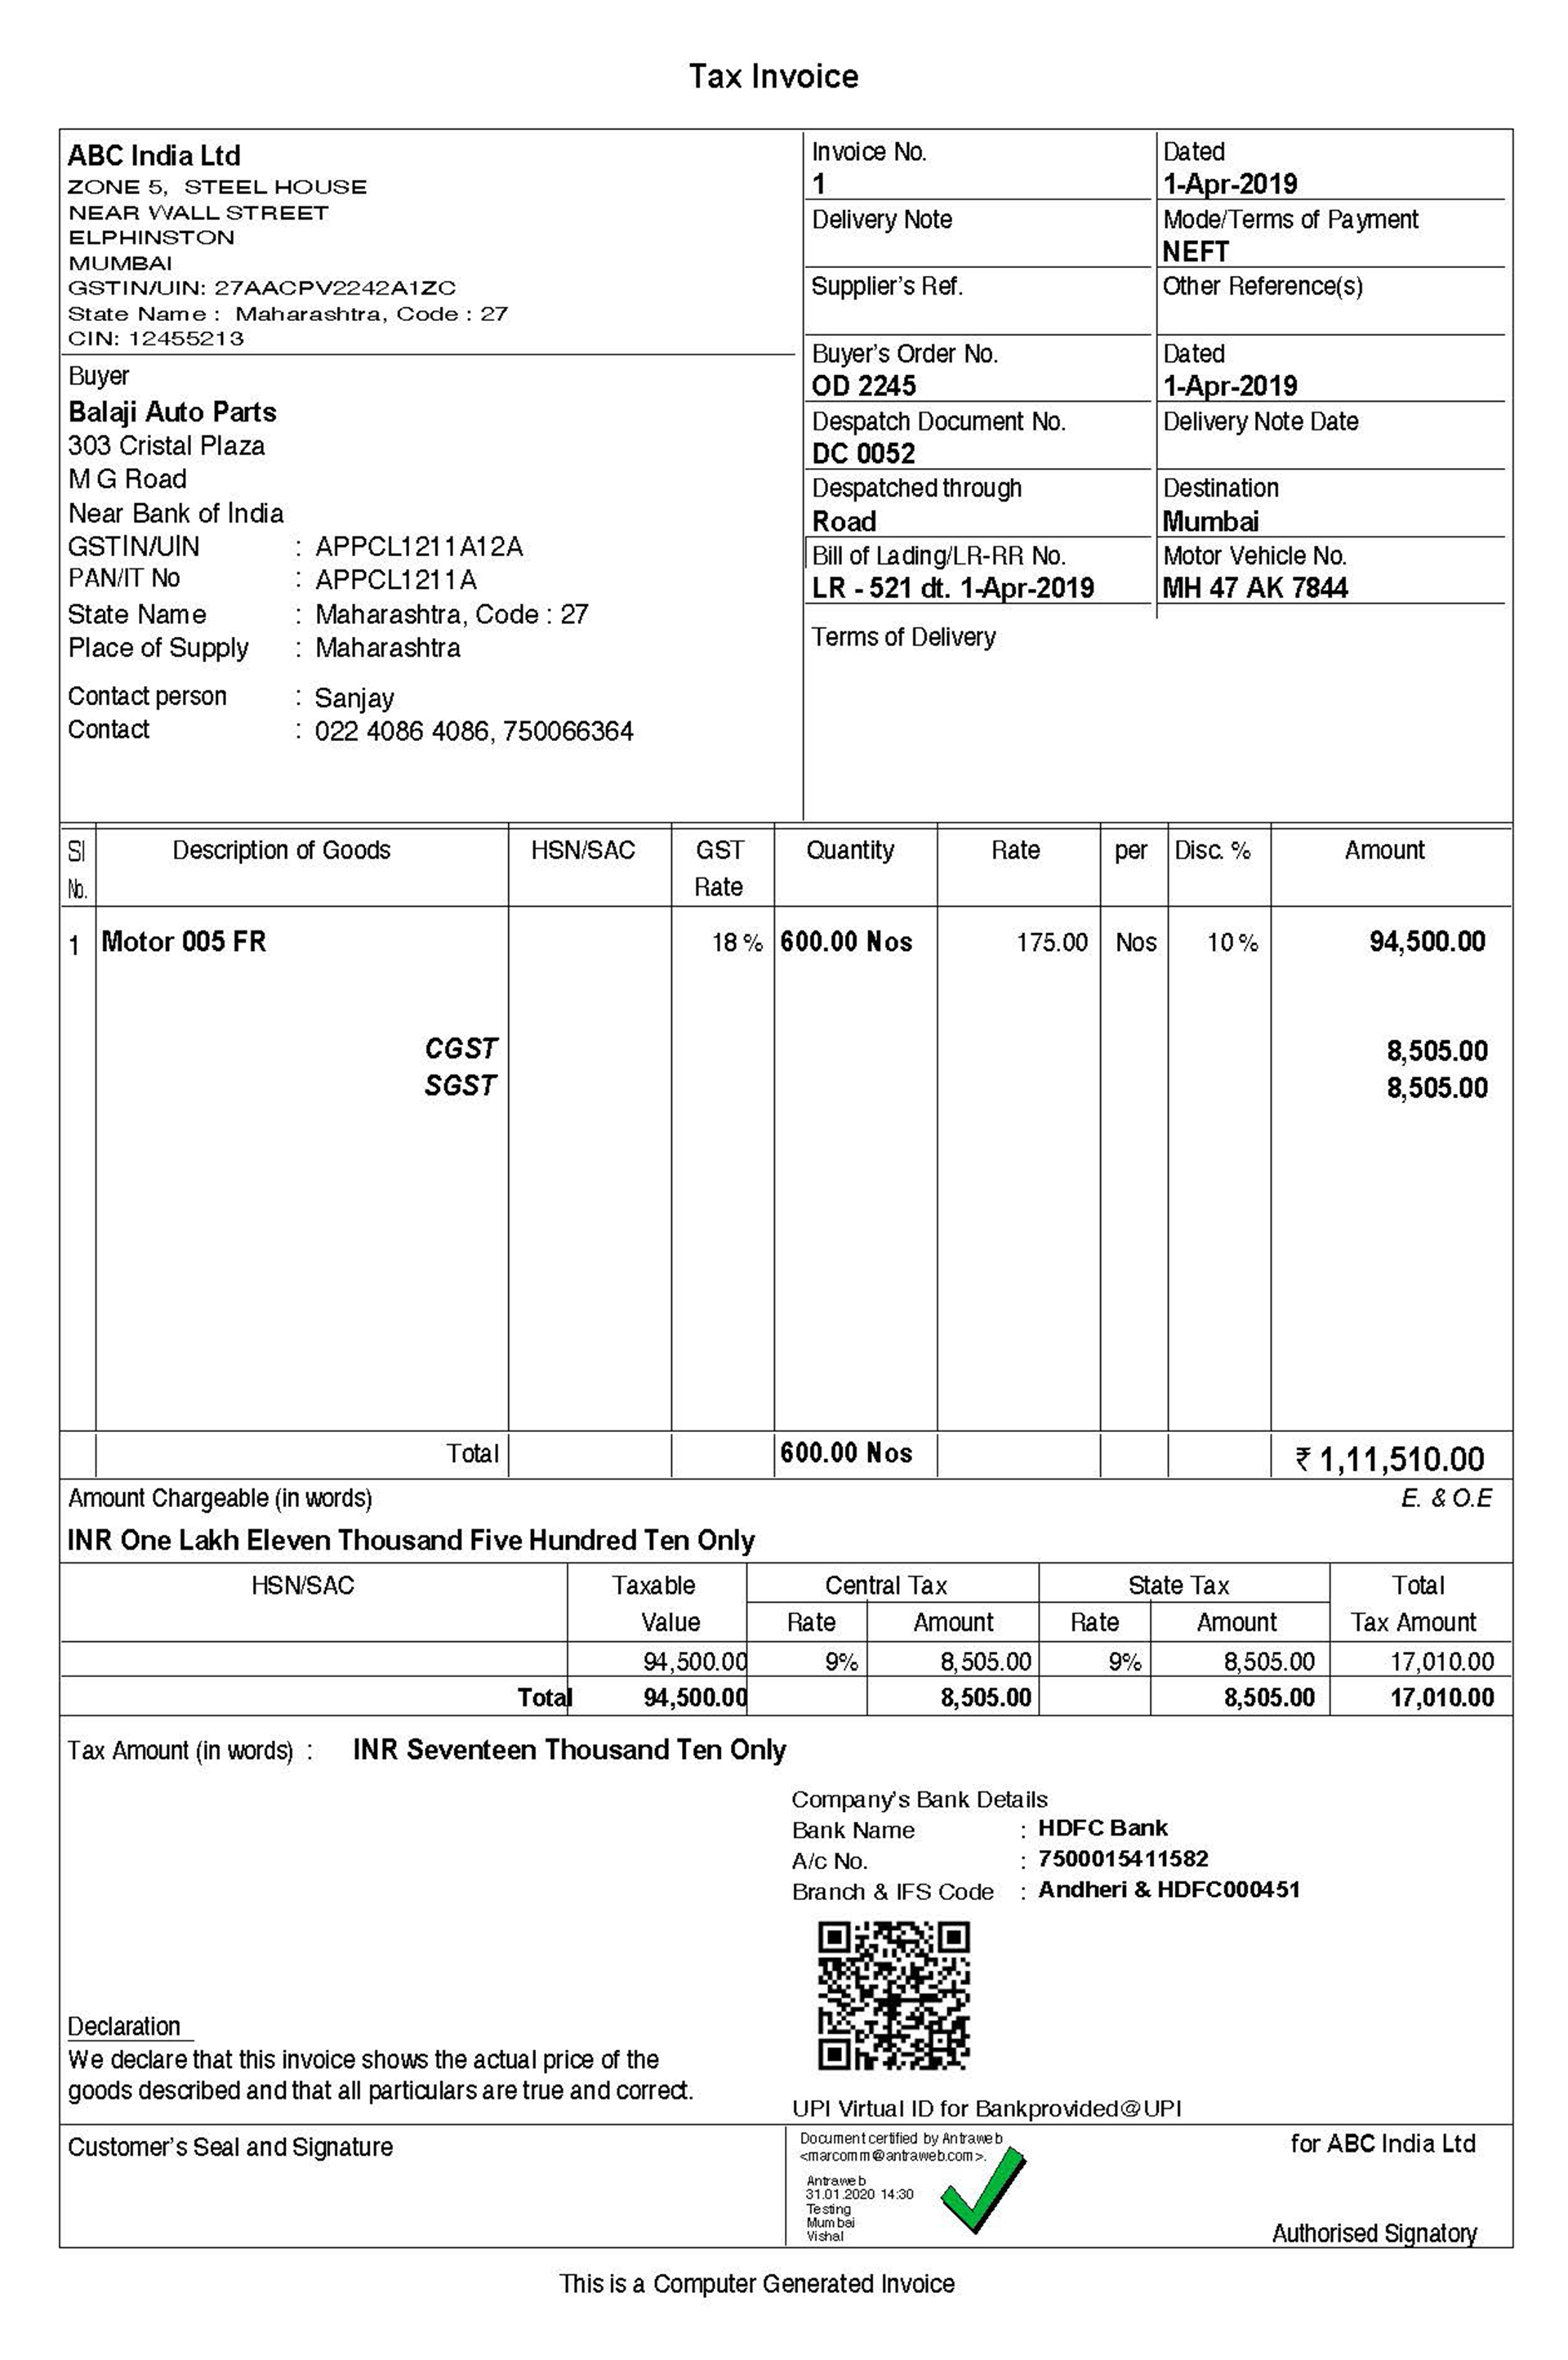

In [ ]:
image_path = 'image02.png'
pil_im = Image.open(image_path)
display(pil_im)

In [ ]:
result_df.filter(result_df.images == f"file:///content/{image_path}").select("class").show()

+---------+
|    class|
+---------+
|no_ticket|
+---------+

